In [1]:
import os
import gc
import copy

import numpy as np
import pandas as pd

import easydict
from tqdm import notebook

#이미지
from PIL import Image

#시각화
import matplotlib.pyplot as plt

#Pytorch
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, Adam\

from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision import transforms

In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [3]:
import timm

In [4]:
config = {}

#설정
config['seed'] = 42
config['device'] = "cuda" if torch.cuda.is_available() else "cpu"

#데이터
config['num_workers'] = 1
config['pin_memory'] = True

#모델
config['hidden_dim'] = 128
config['dropout'] = 0.1

#훈련
config['n_epoch'] = 20
config['batch_size'] = 64
config['lr'] = 0.0001
config['clip_grad'] = 10
config['log_steps'] = 50
config['patience'] = 5

args = easydict.EasyDict(config)

In [5]:
PROJECT_PATH = '/content/drive/MyDrive/hire_test/dataset'

#데이터셋 패스 설정
TRAIN_PATH = os.path.join(PROJECT_PATH, 'train')
TEST_PATH = os.path.join(PROJECT_PATH,'test')

In [6]:
label2idx = {'dog' :0,
             'elephant' : 1,
             'giraffe' : 2,
             'guitar': 3,
             'horse' : 4,
             "house" : 5,
             'person' : 6}

idx2label = {v: k for k, v in label2idx.items()}

In [7]:
#train_df 만들기
labels = []
for path in os.walk(TRAIN_PATH) :
  label_type = path[0].split('/')[-1]
  if label_type == 'train' :
    continue

  base_path = path[0]
  images = path[2]

  idx = label2idx[label_type]
  for image in images :
    img_path = os.path.join(base_path, image)
    label = {'img_path' : img_path,
             'label' : idx}
    labels.append(label)

  train_df = pd.DataFrame(labels)
  train_df = train_df.sort_values(['label', 'img_path'])
  train_df = train_df.reset_index(drop=True)
  train_df.head(5)

In [8]:
train_df.head(5)

,img_path,label
0,/content/drive/MyDrive/hire_test/dataset/train...,0
1,/content/drive/MyDrive/hire_test/dataset/train...,0
2,/content/drive/MyDrive/hire_test/dataset/train...,0
3,/content/drive/MyDrive/hire_test/dataset/train...,0
4,/content/drive/MyDrive/hire_test/dataset/train...,0


In [9]:
#test_df 만들기
labels = []
for path in os.walk(TEST_PATH) :
  base_path = path[0]
  images = path[2]

  for image in images :
    img_path = os.path.join(base_path, image)
    label = {'img_path' : img_path,
             'label' : -1}

    labels.append(label)

test_df = pd.DataFrame(labels)
test_df = test_df.sort_values(['img_path'])
test_df = test_df.reset_index(drop=True)
test_df.head(5)

,img_path,label
0,/content/drive/MyDrive/hire_test/dataset/test/...,-1
1,/content/drive/MyDrive/hire_test/dataset/test/...,-1
2,/content/drive/MyDrive/hire_test/dataset/test/...,-1
3,/content/drive/MyDrive/hire_test/dataset/test/...,-1
4,/content/drive/MyDrive/hire_test/dataset/test/...,-1


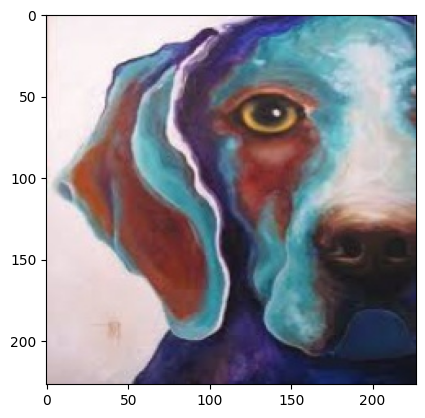

In [10]:
image = plt.imread(train_df['img_path'][0])
plt.imshow(image);

In [11]:
train_df.groupby('label').count()

,img_path
label,
0,329
1,205
2,235
3,134
4,151
5,245
6,399


In [12]:
test_df.count()

img_path    350
label       350
dtype: int64

In [13]:
class ArtDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, idx):
        data = self.df.iloc[idx]

        # 이미지
        img_path = data['img_path']
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        # 라벨
        label = data['label']

        return image, label

    def __len__(self):
        return len(self.df)

In [14]:
transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])

dataset = ArtDataset(train_df, transform)
dataset[7]

(tensor([[[ 1.6495,  1.6838,  1.7009,  ...,  0.7762,  0.6906,  0.7591],
          [ 1.6838,  1.7865,  1.8722,  ...,  0.7419,  0.6563,  0.6221],
          [ 1.6838,  1.9235,  2.0605,  ...,  0.8789,  0.6563,  0.5536],
          ...,
          [-1.3644, -1.6042, -1.6555,  ..., -1.6213, -1.6384, -1.7069],
          [-1.2959, -1.5699, -1.7754,  ..., -1.7925, -1.8439, -1.8268],
          [-1.4158, -1.7069, -1.7583,  ..., -1.9980, -1.9809, -1.9809]],
 
         [[ 1.7458,  1.7983,  1.8508,  ...,  0.2402,  0.2052,  0.2927],
          [ 1.7808,  1.8859,  2.0259,  ...,  0.1176,  0.0651,  0.0651],
          [ 1.7808,  2.0259,  2.2185,  ...,  0.1702, -0.0399, -0.0749],
          ...,
          [-1.4580, -1.7031, -1.7731,  ..., -1.6681, -1.6331, -1.6506],
          [-1.3880, -1.6681, -1.8957,  ..., -1.8256, -1.8431, -1.7556],
          [-1.5105, -1.8081, -1.8606,  ..., -2.0357, -1.9657, -1.9132]],
 
         [[ 1.4548,  1.4722,  1.5245,  ..., -1.3687, -1.2641, -1.0898],
          [ 1.5245,  1.5942,

In [15]:
loader = DataLoader(dataset, shuffle=True, batch_size=32)

for x,y in loader:
  print(x,y)
  break

tensor([[[[-1.3815, -1.4329, -1.5357,  ...,  0.3481,  0.4679,  0.5536],
          [-1.3473, -1.4500, -1.5185,  ...,  0.4679,  0.5193,  0.5878],
          [-1.2445, -1.2617, -1.4158,  ...,  0.5707,  0.5193,  0.5364],
          ...,
          [-1.1932, -1.2103, -1.1760,  ..., -1.2617, -1.1760, -1.2103],
          [-1.0562, -1.2959, -1.2274,  ..., -1.3130, -1.1589, -1.0219],
          [-0.8164, -1.0733, -1.1075,  ..., -1.2959, -0.9534, -0.8849]],

         [[-1.2129, -1.2304, -1.3354,  ...,  1.0280,  1.0630,  1.1506],
          [-1.1779, -1.2479, -1.3179,  ...,  1.1331,  1.0980,  1.1155],
          [-1.0728, -1.0903, -1.2479,  ...,  1.2556,  1.0455,  0.9930],
          ...,
          [-1.1429, -1.1253, -1.1078,  ..., -1.1429, -1.0903, -1.1253],
          [-0.9678, -1.1779, -1.0903,  ..., -1.1954, -1.0728, -0.9503],
          [-0.6702, -0.9153, -0.9678,  ..., -1.1779, -0.8978, -0.8102]],

         [[-1.2293, -1.2467, -1.3513,  ...,  1.7511,  1.6814,  1.6640],
          [-1.1944, -1.2641, -

In [16]:
from sklearn.model_selection import StratifiedKFold

def split_df(df, kfold_n=5):
    kfold = StratifiedKFold(n_splits=kfold_n)

    # 클래스 비율 고려하여 Fold별로 데이터 나눔
    X = df.img_path.values
    y = df.label.values

    datas = []
    for i, (train_index, valid_index) in enumerate(kfold.split(X, y)):
        train_df = df.iloc[train_index].copy().reset_index(drop=True)
        valid_df = df.iloc[valid_index].copy().reset_index(drop=True)

        datas.append((train_df, valid_df))

    return datas

In [17]:
datas = split_df(train_df)

In [18]:
# 첫번째 데이터셋 train
datas[0][0].groupby('label').count()

,img_path
label,
0,263
1,164
2,188
3,107
4,121
5,196
6,319


In [19]:
# 첫번째 데이터셋 valid
datas[0][1].groupby('label').count()

,img_path
label,
0,66
1,41
2,47
3,27
4,30
5,49
6,80


###get_loader

In [20]:
def get_loader(train_data, valid_data, transform):
    train_dataset = ArtDataset(train_data, transform)
    valid_dataset = ArtDataset(valid_data, transform)


    train_loader = DataLoader(train_dataset,
                              shuffle=True,
                              num_workers=args.num_workers,
                              batch_size=args.batch_size,
                              pin_memory=args.pin_memory)
    valid_loader = DataLoader(valid_dataset,
                              shuffle=False,
                              num_workers=args.num_workers,
                              batch_size=args.batch_size,
                              pin_memory=args.pin_memory)

    return train_loader, valid_loader

###모델

conv모델(간단한 convolution 모델을 사용해서 테스트하는 용도)

In [21]:
for X, y in loader:
    print(X.size(), y.size())
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [22]:
class ConvNet(nn.Module):
    def __init__(self, args, class_n=7):
        super().__init__()

        self.model = nn.Sequential(
            # [32, 3, 224, 224] -> [32, 32, 55, 55]
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)), # [32, 64, 55, 55] -> [32, 64, 27, 27]

            # [32, 32, 27, 27] -> [32, 64, 11, 11]
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)), # [32, 64, 11, 11] -> [32, 64, 5, 5]
        )
        self.fc = nn.Linear(1600, class_n)


    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [23]:
model = ConvNet(args)
model(X)

tensor([[ 0.4385, -0.4577, -0.3085, -0.6194, -0.6588, -0.3372,  0.3718],
        [ 0.4620,  1.1254, -0.6564,  0.3202, -0.0830, -0.1190, -0.3037],
        [ 0.4626, -0.2235, -0.5716, -0.2093, -0.6120,  0.0092,  0.6664],
        [ 0.4180, -0.3917, -0.0869, -0.9600, -0.5660, -0.4411,  0.1308],
        [-0.1709,  0.3478, -0.2714, -0.4186, -0.6982, -0.7390,  0.3130],
        [ 0.2382,  0.1971, -0.0953, -0.4374, -0.4247, -0.3379,  0.0241],
        [ 0.2134,  0.0655,  0.3106,  0.1102,  0.1495,  0.3637,  0.3981],
        [-0.4263,  0.1358, -0.3986,  0.0779,  0.3734,  0.2984,  0.5198],
        [ 0.5651,  1.0581, -0.5768, -1.0293, -0.0341,  0.0174, -0.2030],
        [ 0.2164, -0.3197, -0.3451, -0.6802, -0.2733, -0.0150,  0.0637],
        [ 0.4584,  0.8647, -0.5592, -0.4573, -0.1988, -0.3247, -0.1189],
        [-0.2235,  0.5300,  0.0346, -0.2037,  0.0897,  0.3407,  0.2423],
        [-0.0292,  0.1753,  0.1399, -0.8395, -0.8949,  0.1048,  1.0870],
        [-0.4228,  0.1488, -0.7181, -0.7810,  0.024

###efficientnet1

In [24]:
class Eff01(nn.Module):
    def __init__(self, args, class_n=7):
        super().__init__()
        self.model = timm.create_model('efficientnet_b1', pretrained=True, num_classes=class_n)

    def forward(self, x):
        x = self.model(x)
        return x

In [25]:
model = Eff01(args)
model(X)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

tensor([[-3.4518e+00, -2.1694e+00,  7.0232e-01,  1.3301e+00, -5.9309e-01,
         -1.9622e+00,  6.5393e+00],
        [ 3.3278e-01, -8.0304e-01,  7.3318e-03,  2.7217e+00, -2.5695e+00,
         -1.0831e-01,  2.4050e-01],
        [ 5.2765e+00,  1.1692e+00,  9.4533e+00,  6.6836e-01, -3.7463e-01,
          1.2260e+00,  1.2962e+00],
        [-1.4327e+00,  1.7820e+00, -5.1792e-01, -2.2172e+00,  1.0924e+00,
         -3.7883e+00,  4.5296e+00],
        [-1.5028e+00,  5.3951e-01,  1.3497e+00,  2.1833e+00,  6.7985e-02,
         -5.0040e+00,  3.1367e+00],
        [-4.5714e+00, -2.1770e+00, -2.1866e+00, -2.7556e+00,  2.5566e+00,
          1.9918e+00,  2.3755e+00],
        [-7.0861e+00,  7.4674e+00, -3.4423e-01,  3.8999e+00,  4.1540e+00,
         -1.1510e+00,  2.5154e+00],
        [-2.2062e+00, -1.5453e+00,  2.0569e+00,  4.7431e+00,  2.8532e-01,
         -2.5752e+00, -2.7313e+00],
        [ 2.8254e+00,  3.6464e+00,  1.3623e+00,  2.1203e+00,  1.5976e+00,
         -1.5431e+00, -2.1727e-01],
        [-

###timm
timm이 제공하는 다양한 모델을 마음대로 가져다쓰기 위한 모델

In [26]:
class Timm(nn.Module):
    def __init__(self, args, class_n=7):
        super().__init__()
        self.model = timm.create_model(args.timm_model, pretrained=True, num_classes=class_n)

    def forward(self, x):
        x = self.model(x)
        return x

###훈련
초기 세팅

In [27]:
config = {}

# 설정
config['seed'] = 42
config['device'] = "cuda" if torch.cuda.is_available() else "cpu"
config['model_path'] = os.path.join(PROJECT_PATH, 'model')

# 데이터
config['num_workers'] = 1
config['pin_memory'] = False

# 모델
config['dropout'] = 0.1

# 훈련
config['n_epochs'] = 20
config['lr'] = 0.0001
config['batch_size'] = 32
config['clip_grad'] = 10
config['log_steps'] = 1
config['patience'] = 10

config['model'] = 'timm'
config['timm_model'] = 'vit_deit_base_distilled_patch16_224'

config['optimizer'] = 'adam'
config['scheduler'] = 'plateau'

config['load'] = False
config['model_name'] = ""

config['kfold'] = 1

config['pseudo_labeling'] = False
config['pseudo_iter_n'] = 2

args = easydict.EasyDict(config)

###criterion

In [28]:
criterion = nn.CrossEntropyLoss()

###get_model

In [29]:
def get_model(args):
    """
    Load model and move tensors to a given devices.
    """
    if args.model == 'convnet': model = ConvNet(args)
    if args.model == 'eff1': model = Eff01(args)
    if args.model == 'eff3': model = Eff03(args)
    if args.model == 'timm': model = Timm(args)

    model.to(args.device)

    return model

###get_optimizer

In [30]:
def get_optimizer(model, args):
    if args.optimizer == 'adam':
        optimizer = Adam(model.parameters(), lr=args.lr, weight_decay=0.0)

    # 모든 parameter들의 grad값을 0으로 초기화
    optimizer.zero_grad()

    return optimizer

###get_scheduler

In [31]:
def get_scheduler(optimizer, args):
    if args.scheduler == 'plateau':
        scheduler = ReduceLROnPlateau(optimizer, patience=3, factor=0.5, mode='max', verbose=True)

    return scheduler

###train

In [32]:
def train(args, model, train_loader, optimizer):
    model.train()

    corrects = 0

    for step, (images, labels) in enumerate(train_loader):
        images = images.to(args.device)
        labels = labels.to(args.device)

        outputs = model(images)
        if args.timm_model == 'vit_deit_base_distilled_patch16_224':
            outputs = outputs[0]

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        if step % args.log_steps == 0:
            print(f"Training steps: {step} Loss: {str(loss.item())}")

        _, preds = torch.max(outputs, 1)

        corrects += torch.sum(preds == labels.data)

    acc = corrects / args.train_len

    return acc

###validate

In [33]:
def validate(args, model, valid_loader):
    model.eval()

    corrects = 0

    for images, labels in valid_loader:
        images = images.to(args.device)
        labels = labels.to(args.device)


        outputs = model(images)

        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)

    acc = corrects / args.valid_len

    print(f'VALID ACC : {acc}\n')

    return acc, outputs

###pseudo_labeling

In [34]:
def pseudo_labeling(args, model, train_data):
    # train_data에 새로운 df
    new_train_data = copy.deepcopy(test_df)

    test_dataset = ArtDataset(test_df, transform)
    test_loader = DataLoader(test_dataset,
                            shuffle=False,
                            num_workers=args.num_workers,
                            batch_size=args.batch_size,
                            pin_memory=args.pin_memory)
    model.eval()
    answers = []
    for images, labels in test_loader:
        images = images.to(args.device)
        labels = labels.to(args.device)

        outputs = model(images)

        _, preds = torch.max(outputs, 1)

        answers.extend(list(preds.cpu().numpy()))

    new_train_data.label = answers

    new_train_data = pd.concat([train_data, new_train_data]).reset_index(drop=True)

    return new_train_data

###run

In [35]:
def run(args, train_data, valid_data):
    """데이터셋을 주면 처음부터 끝까지 훈련 사이클을 실행"""

    # 캐시 메모리 비우기 및 가비지 컬렉터 가동!
    torch.cuda.empty_cache()
    gc.collect()

    # 데이터 로드
    args.train_len = len(train_data)
    args.valid_len = len(valid_data)
    transform = transforms.Compose([transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])
    train_loader, valid_loader = get_loader(train_data, valid_data, transform)

    if args.load:
        model = torch.load(os.path.join(args.model_path, args.model_name))
    else:
        model = get_model(args)
    optimizer = get_optimizer(model, args)
    scheduler = get_scheduler(optimizer, args)

    early_stopping_counter = 0
    best_acc = -1

    if args.pseudo_labeling:
        iter_n = args.pseudo_iter_n
    else:
        iter_n = 1

    # pseudo labeling을 위한 iteration
    for iter_i in range(iter_n):
        for epoch in notebook.tqdm(range(args.n_epochs)):
            print(f'Epoch {epoch + 1}/{args.n_epochs}')

            ### TRAIN
            train_acc = train(args, model, train_loader, optimizer)

            ### VALID
            valid_acc, outputs = validate(args, model, valid_loader)

            ### model save and early stopping
            if valid_acc > best_acc:
                best_acc = valid_acc
                early_stopping_counter = 0

                # 모델 저장!
                if args.model == 'timm':
                    save_name = f"{args.timm_model}_fold{args.kfold}_{str(best_acc.item())[:4]}"
                else:
                    save_name = f"{args.model}_fold{args.kfold}_{str(best_acc.item())[:4]}"

                torch.save(model, os.path.join(args.model_path, save_name))
                print(f'model saved! {save_name}')
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= args.patience:
                    print(f'EarlyStopping counter: {early_stopping_counter} out of {args.patience}')
                    break

            # scheduler
            if args.scheduler == 'plateau':
                scheduler.step(best_acc)

        # Pseudo Labeling
        if args.pseudo_labeling:
            print('pseudo labeing ongoing!')
            train_data = pseudo_labeling(args, model, train_data)

            # make a loader with new train data
            train_loader, _ = get_loader(train_data, valid_data, transform)

###데이터 불러오기

In [36]:
datas = split_df(train_df)

# 하나의 fold만 사용
train_data = datas[args.kfold - 1][0]
valid_data = datas[args.kfold - 1][1]

###훈련 진행

In [37]:
args.lr = 0.0001
args.load = False
args.model_name = ''

args.batch_size = 16
args.log_steps = 20

args.patience = 10

In [38]:
timm.list_models(pretrained=True)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

In [42]:
!mkdir -p /content/drive/MyDrive/hire_test/dataset/model

In [39]:
# args.timm_model = 'vit_deit_base_distilled_patch16_224'
args.timm_model = 'ecaresnet50t'
# args.timm_model = 'seresnext50_32x4d'
# args.timm_model = 'tf_efficientnet_b3_ns'
# args.timm_model = 'eca_nfnet_l0'
# args.timm_model = 'resnest50d'
# args.timm_model = 'regnety_016'

In [40]:
# pseudo labeling
args.pseudo_labeling = True
args.pseudo_iter_n = 3

args.n_epochs = 3

In [43]:
run(args, train_data, valid_data)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 1.9982990026474
Training steps: 20 Loss: 1.5258692502975464
Training steps: 40 Loss: 1.5953664779663086
Training steps: 60 Loss: 1.2658770084381104
Training steps: 80 Loss: 0.7579024434089661
VALID ACC : 0.929411768913269

model saved! ecaresnet50t_fold1_0.92
Epoch 2/3
Training steps: 0 Loss: 0.5995534658432007
Training steps: 20 Loss: 0.3472306728363037
Training steps: 40 Loss: 0.3276720345020294
Training steps: 60 Loss: 0.3438366651535034
Training steps: 80 Loss: 0.3089415431022644
VALID ACC : 0.9764705896377563

model saved! ecaresnet50t_fold1_0.97
Epoch 3/3
Training steps: 0 Loss: 0.07161462306976318
Training steps: 20 Loss: 0.07056154310703278
Training steps: 40 Loss: 0.08632569015026093
Training steps: 60 Loss: 0.04711223021149635
Training steps: 80 Loss: 0.1564558446407318
VALID ACC : 0.979411780834198

model saved! ecaresnet50t_fold1_0.97
pseudo labeing ongoing!


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 0.049492307007312775
Training steps: 20 Loss: 0.031571999192237854
Training steps: 40 Loss: 0.23535853624343872
Training steps: 60 Loss: 0.08295918256044388
Training steps: 80 Loss: 0.014853120781481266
Training steps: 100 Loss: 0.5056806206703186
VALID ACC : 0.9764705896377563

Epoch 2/3
Training steps: 0 Loss: 0.05241373926401138
Training steps: 20 Loss: 0.011679238639771938
Training steps: 40 Loss: 0.06819428503513336
Training steps: 60 Loss: 0.11303619295358658
Training steps: 80 Loss: 0.23577213287353516
Training steps: 100 Loss: 0.0278980303555727
VALID ACC : 0.9852941632270813

model saved! ecaresnet50t_fold1_0.98
Epoch 3/3
Training steps: 0 Loss: 0.11680585145950317
Training steps: 20 Loss: 0.008174610324203968
Training steps: 40 Loss: 0.01750088296830654
Training steps: 60 Loss: 0.007324618753045797
Training steps: 80 Loss: 0.03532018885016441
Training steps: 100 Loss: 0.05072323605418205
VALID ACC : 0.9764705896377563

pseudo labeing ongoing!

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 0.03312519192695618
Training steps: 20 Loss: 0.0160162802785635
Training steps: 40 Loss: 0.01815979927778244
Training steps: 60 Loss: 0.04143182188272476
Training steps: 80 Loss: 0.004060197621583939
Training steps: 100 Loss: 0.010730518028140068
Training steps: 120 Loss: 0.006259709596633911
VALID ACC : 0.979411780834198

Epoch 2/3
Training steps: 0 Loss: 0.008738229051232338
Training steps: 20 Loss: 0.017034975811839104
Training steps: 40 Loss: 0.02038348652422428
Training steps: 60 Loss: 0.03252940624952316
Training steps: 80 Loss: 0.004931054078042507
Training steps: 100 Loss: 0.009242421016097069
Training steps: 120 Loss: 0.005476060789078474
VALID ACC : 0.9764705896377563

Epoch 3/3
Training steps: 0 Loss: 0.008834389969706535
Training steps: 20 Loss: 0.004129804205149412
Training steps: 40 Loss: 0.005641722586005926
Training steps: 60 Loss: 0.004610742907971144
Training steps: 80 Loss: 0.004888345021754503
Training steps: 100 Loss: 0.00188863778

###추론

In [45]:
test_dataset = ArtDataset(test_df, transform)
test_loader = DataLoader(test_dataset,
                         shuffle=False,
                         num_workers=args.num_workers,
                         batch_size=args.batch_size,
                         pin_memory=args.pin_memory)

In [46]:
torch.cuda.empty_cache()
gc.collect()

36

In [48]:
infer_model_name = 'timm_0.99'
infer_model_name = 'ecaresnet50t_0.98'
infer_model_name = 'ecaresnet50t_fold1_0.97'


model = torch.load(os.path.join(args.model_path, infer_model_name))

In [49]:
model.eval()
answers = []
for images, labels in test_loader:
    images = images.to(args.device)
    labels = labels.to(args.device)

    outputs = model(images)

    _, preds = torch.max(outputs, 1)

    answers.extend(list(preds.cpu().numpy()))

In [51]:
print(answers)

[2, 3, 3, 3, 3, 3, 4, 4, 3, 1, 6, 2, 0, 2, 3, 1, 2, 4, 6, 3, 3, 5, 2, 3, 0, 5, 1, 2, 0, 5, 1, 5, 6, 2, 0, 5, 5, 4, 2, 1, 4, 0, 2, 3, 1, 3, 0, 5, 5, 2, 6, 5, 4, 1, 5, 0, 4, 5, 1, 1, 5, 0, 6, 1, 1, 2, 4, 1, 1, 3, 1, 3, 0, 1, 1, 6, 2, 0, 3, 4, 1, 6, 1, 6, 6, 4, 3, 6, 1, 2, 2, 5, 1, 0, 5, 6, 3, 3, 1, 6, 5, 6, 6, 0, 3, 2, 5, 3, 0, 2, 4, 6, 2, 5, 4, 2, 0, 0, 5, 6, 4, 2, 2, 6, 4, 1, 5, 6, 0, 4, 1, 1, 6, 4, 4, 2, 5, 6, 5, 0, 4, 3, 1, 5, 1, 5, 4, 0, 2, 5, 6, 1, 6, 3, 2, 2, 0, 1, 4, 5, 2, 0, 6, 2, 3, 4, 1, 5, 6, 2, 1, 5, 3, 0, 0, 3, 2, 5, 3, 4, 2, 0, 3, 6, 0, 3, 3, 2, 0, 4, 4, 2, 2, 0, 4, 6, 6, 6, 3, 2, 5, 5, 4, 6, 2, 1, 3, 6, 0, 2, 3, 1, 1, 3, 1, 5, 2, 2, 0, 0, 6, 1, 2, 2, 6, 6, 3, 2, 5, 4, 3, 5, 0, 2, 4, 5, 0, 6, 4, 1, 6, 1, 2, 1, 6, 0, 5, 4, 6, 3, 4, 2, 5, 3, 1, 4, 2, 3, 4, 0, 6, 0, 2, 0, 1, 0, 1, 4, 0, 1, 1, 5, 6, 4, 6, 2, 4, 0, 3, 6, 6, 4, 0, 3, 3, 3, 0, 0, 5, 2, 5, 5, 2, 5, 2, 6, 5, 1, 5, 1, 5, 3, 0, 3, 3, 1, 6, 5, 0, 4, 0, 4, 3, 4, 4, 2, 5, 1, 2, 0, 6, 6, 1, 2, 3, 0, 0, 5, 2, 4, 6, 6, 6, 

In [52]:
label2idx

{'dog': 0,
 'elephant': 1,
 'giraffe': 2,
 'guitar': 3,
 'horse': 4,
 'house': 5,
 'person': 6}

In [53]:
submission_path = os.path.join(PROJECT_PATH, 'submission.csv')
submission_df = pd.DataFrame({'answer_value': answers})
submission_df.to_csv(submission_path)

In [54]:
submission_df.value_counts()

answer_value
2               54
6               52
0               50
1               50
3               50
5               50
4               44
dtype: int64

###앙상블

####KFOLD 훈련

In [56]:
# args.timm_model = 'vit_deit_base_distilled_patch16_224'
args.timm_model = 'ecaresnet50t'
# args.timm_model = 'seresnext50_32x4d'
# args.timm_model = 'tf_efficientnet_b3_ns'
# args.timm_model = 'eca_nfnet_l0'
# args.timm_model = 'resnest50d'
# args.timm_model = 'regnety_016'

In [57]:
args.lr = 0.0001
args.load = False
args.model_name = ''

args.batch_size = 16
args.log_steps = 20

args.patience = 5

In [58]:
kfold_n = 5
datas = split_df(train_df)
for fold in range(1, kfold_n + 1):
    args.kfold = fold

    # 하나의 fold만 사용
    train_data = datas[args.kfold - 1][0]
    valid_data = datas[args.kfold - 1][1]
    run(args, train_data, valid_data)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 1.9757888317108154
Training steps: 20 Loss: 1.6688646078109741
Training steps: 40 Loss: 1.4332048892974854
Training steps: 60 Loss: 0.9800220727920532
Training steps: 80 Loss: 0.8159624338150024
VALID ACC : 0.9323529601097107

model saved! ecaresnet50t_fold1_0.93
Epoch 2/3
Training steps: 0 Loss: 0.594186007976532
Training steps: 20 Loss: 0.5589601993560791
Training steps: 40 Loss: 0.33811619877815247
Training steps: 60 Loss: 0.18129977583885193
Training steps: 80 Loss: 0.37844187021255493
VALID ACC : 0.9735294580459595

model saved! ecaresnet50t_fold1_0.97
Epoch 3/3
Training steps: 0 Loss: 0.2355385273694992
Training steps: 20 Loss: 0.12223514914512634
Training steps: 40 Loss: 0.11795368045568466
Training steps: 60 Loss: 0.1090446338057518
Training steps: 80 Loss: 0.04595945402979851
VALID ACC : 0.9735294580459595

pseudo labeing ongoing!


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 0.04355838522315025
Training steps: 20 Loss: 0.1566389799118042
Training steps: 40 Loss: 0.09425388276576996
Training steps: 60 Loss: 0.023789629340171814
Training steps: 80 Loss: 0.13746915757656097
Training steps: 100 Loss: 0.08499321341514587
VALID ACC : 0.9823529720306396

model saved! ecaresnet50t_fold1_0.98
Epoch 2/3
Training steps: 0 Loss: 0.01075725071132183
Training steps: 20 Loss: 0.035189807415008545
Training steps: 40 Loss: 0.00790011789649725
Training steps: 60 Loss: 0.06515609472990036
Training steps: 80 Loss: 0.007521089632064104
Training steps: 100 Loss: 0.020873595029115677
VALID ACC : 0.9764705896377563

Epoch 3/3
Training steps: 0 Loss: 0.004934761207550764
Training steps: 20 Loss: 0.031856469810009
Training steps: 40 Loss: 0.004151209723204374
Training steps: 60 Loss: 0.07124827057123184
Training steps: 80 Loss: 0.013844535686075687
Training steps: 100 Loss: 0.045810844749212265
VALID ACC : 0.9735294580459595

pseudo labeing ongoing

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 0.13176235556602478
Training steps: 20 Loss: 0.20403356850147247
Training steps: 40 Loss: 0.022633962333202362
Training steps: 60 Loss: 0.01618269644677639
Training steps: 80 Loss: 0.020092798396945
Training steps: 100 Loss: 0.025547228753566742
Training steps: 120 Loss: 0.03167431056499481
VALID ACC : 0.9764705896377563

Epoch 2/3
Training steps: 0 Loss: 0.0053908671252429485
Training steps: 20 Loss: 0.06230922415852547
Training steps: 40 Loss: 0.01226435974240303
Training steps: 60 Loss: 0.009617350995540619
Training steps: 80 Loss: 0.03701413795351982
Training steps: 100 Loss: 0.004646082408726215
Training steps: 120 Loss: 0.002756498521193862
VALID ACC : 0.9764705896377563

Epoch 3/3
Training steps: 0 Loss: 0.0030466578900814056
Training steps: 20 Loss: 0.26399552822113037
Training steps: 40 Loss: 0.0059808469377458096
Training steps: 60 Loss: 0.004162037279456854
Training steps: 80 Loss: 0.0029053338803350925
Training steps: 100 Loss: 0.0063085705

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 1.9257863759994507
Training steps: 20 Loss: 1.6397098302841187
Training steps: 40 Loss: 1.4426989555358887
Training steps: 60 Loss: 1.1427353620529175
Training steps: 80 Loss: 0.838671863079071
VALID ACC : 0.9264705777168274

model saved! ecaresnet50t_fold2_0.92
Epoch 2/3
Training steps: 0 Loss: 0.5981000065803528
Training steps: 20 Loss: 0.451754629611969
Training steps: 40 Loss: 0.21739348769187927
Training steps: 60 Loss: 0.13341911137104034
Training steps: 80 Loss: 0.3384612798690796
VALID ACC : 0.9676470756530762

model saved! ecaresnet50t_fold2_0.96
Epoch 3/3
Training steps: 0 Loss: 0.14532756805419922
Training steps: 20 Loss: 0.05132552236318588
Training steps: 40 Loss: 0.08990062773227692
Training steps: 60 Loss: 0.05845900624990463
Training steps: 80 Loss: 0.13184058666229248
VALID ACC : 0.9735294580459595

model saved! ecaresnet50t_fold2_0.97
pseudo labeing ongoing!


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 0.02074156329035759
Training steps: 20 Loss: 0.26791971921920776
Training steps: 40 Loss: 0.12924525141716003
Training steps: 60 Loss: 0.3712359666824341
Training steps: 80 Loss: 0.012822878547012806
Training steps: 100 Loss: 0.09657423943281174
VALID ACC : 0.9705882668495178

Epoch 2/3
Training steps: 0 Loss: 0.045726433396339417
Training steps: 20 Loss: 0.21115858852863312
Training steps: 40 Loss: 0.00976969301700592
Training steps: 60 Loss: 0.020148862153291702
Training steps: 80 Loss: 0.02241571992635727
Training steps: 100 Loss: 0.009359077550470829
VALID ACC : 0.9764705896377563

model saved! ecaresnet50t_fold2_0.97
Epoch 3/3
Training steps: 0 Loss: 0.008217203430831432
Training steps: 20 Loss: 0.021848037838935852
Training steps: 40 Loss: 0.005221653264015913
Training steps: 60 Loss: 0.003303979290649295
Training steps: 80 Loss: 0.018105782568454742
Training steps: 100 Loss: 0.003201499581336975
VALID ACC : 0.9705882668495178

pseudo labeing ong

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 0.03525450453162193
Training steps: 20 Loss: 0.13810591399669647
Training steps: 40 Loss: 0.024042896926403046
Training steps: 60 Loss: 0.004383142106235027
Training steps: 80 Loss: 0.004789515398442745
Training steps: 100 Loss: 0.15891742706298828
Training steps: 120 Loss: 0.005365162622183561
VALID ACC : 0.979411780834198

model saved! ecaresnet50t_fold2_0.97
Epoch 2/3
Training steps: 0 Loss: 0.027409402653574944
Training steps: 20 Loss: 0.021619446575641632
Training steps: 40 Loss: 0.04867570474743843
Training steps: 60 Loss: 0.023522119969129562
Training steps: 80 Loss: 0.048562146723270416
Training steps: 100 Loss: 0.00729322899132967
Training steps: 120 Loss: 0.006771651096642017
VALID ACC : 0.9823529720306396

model saved! ecaresnet50t_fold2_0.98
Epoch 3/3
Training steps: 0 Loss: 0.06799018383026123
Training steps: 20 Loss: 0.0011059335665777326
Training steps: 40 Loss: 0.013923156075179577
Training steps: 60 Loss: 0.0065203397534787655
Training

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 1.9708479642868042
Training steps: 20 Loss: 1.6869322061538696
Training steps: 40 Loss: 1.2991740703582764
Training steps: 60 Loss: 1.104331612586975
Training steps: 80 Loss: 0.8545132875442505
VALID ACC : 0.9441176652908325

model saved! ecaresnet50t_fold3_0.94
Epoch 2/3
Training steps: 0 Loss: 0.505780041217804
Training steps: 20 Loss: 0.2902304530143738
Training steps: 40 Loss: 0.3732016086578369
Training steps: 60 Loss: 0.28322088718414307
Training steps: 80 Loss: 0.4119475781917572
VALID ACC : 0.979411780834198

model saved! ecaresnet50t_fold3_0.97
Epoch 3/3
Training steps: 0 Loss: 0.06972980499267578
Training steps: 20 Loss: 0.2684478759765625
Training steps: 40 Loss: 0.10689021646976471
Training steps: 60 Loss: 0.039606690406799316
Training steps: 80 Loss: 0.13216085731983185
VALID ACC : 0.9705882668495178

pseudo labeing ongoing!


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 0.11884311586618423
Training steps: 20 Loss: 0.031098894774913788
Training steps: 40 Loss: 0.06077202036976814
Training steps: 60 Loss: 0.08628559857606888
Training steps: 80 Loss: 0.03994535282254219
Training steps: 100 Loss: 0.19931526482105255
VALID ACC : 0.9617647528648376

Epoch 2/3
Training steps: 0 Loss: 0.019648341462016106
Training steps: 20 Loss: 0.0786866843700409
Training steps: 40 Loss: 0.0095649603754282
Training steps: 60 Loss: 0.1260349601507187
Training steps: 80 Loss: 0.2999170422554016
Training steps: 100 Loss: 0.013228342868387699
VALID ACC : 0.9676470756530762

Epoch 3/3
Training steps: 0 Loss: 0.005212266929447651
Training steps: 20 Loss: 0.07387802749872208
Training steps: 40 Loss: 0.004107504151761532
Training steps: 60 Loss: 0.02423620969057083
Training steps: 80 Loss: 0.009733287617564201
Training steps: 100 Loss: 0.0036770792212337255
VALID ACC : 0.9617647528648376

pseudo labeing ongoing!


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 0.00835901964455843
Training steps: 20 Loss: 0.038477059453725815
Training steps: 40 Loss: 0.002158563816919923
Training steps: 60 Loss: 0.011258716695010662
Training steps: 80 Loss: 0.004422343801707029
Training steps: 100 Loss: 0.0032226801849901676
Training steps: 120 Loss: 0.004588551353663206
VALID ACC : 0.9647058844566345

EarlyStopping counter: 5 out of 5
pseudo labeing ongoing!


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 1.9493094682693481
Training steps: 20 Loss: 1.6785540580749512
Training steps: 40 Loss: 1.445730447769165
Training steps: 60 Loss: 1.1095235347747803
Training steps: 80 Loss: 0.6532037258148193
VALID ACC : 0.9026548862457275

model saved! ecaresnet50t_fold4_0.90
Epoch 2/3
Training steps: 0 Loss: 0.8746267557144165
Training steps: 20 Loss: 0.3525598347187042
Training steps: 40 Loss: 0.3781135380268097
Training steps: 60 Loss: 0.37008148431777954
Training steps: 80 Loss: 0.23837077617645264
VALID ACC : 0.9469026327133179

model saved! ecaresnet50t_fold4_0.94
Epoch 3/3
Training steps: 0 Loss: 0.0888935849070549
Training steps: 20 Loss: 0.04409670829772949
Training steps: 40 Loss: 0.029264573007822037
Training steps: 60 Loss: 0.13503354787826538
Training steps: 80 Loss: 0.07546840608119965
VALID ACC : 0.9498525261878967

model saved! ecaresnet50t_fold4_0.94
pseudo labeing ongoing!


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 0.08591121435165405
Training steps: 20 Loss: 0.02868306264281273
Training steps: 40 Loss: 0.14185503125190735
Training steps: 60 Loss: 0.3544500470161438
Training steps: 80 Loss: 0.014870995655655861
Training steps: 100 Loss: 0.06793961673974991
VALID ACC : 0.9439527988433838

Epoch 2/3
Training steps: 0 Loss: 0.01910701021552086
Training steps: 20 Loss: 0.02541172504425049
Training steps: 40 Loss: 0.012928883545100689
Training steps: 60 Loss: 0.015484683215618134
Training steps: 80 Loss: 0.03740927204489708
Training steps: 100 Loss: 0.12384583055973053
VALID ACC : 0.9616519212722778

model saved! ecaresnet50t_fold4_0.96
Epoch 3/3
Training steps: 0 Loss: 0.07263091206550598
Training steps: 20 Loss: 0.025532471016049385
Training steps: 40 Loss: 0.04661722108721733
Training steps: 60 Loss: 0.10079097002744675
Training steps: 80 Loss: 0.002947005210444331
Training steps: 100 Loss: 0.04161274433135986
VALID ACC : 0.9557521939277649

pseudo labeing ongoing!

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 0.0031149382703006268
Training steps: 20 Loss: 0.002289478201419115
Training steps: 40 Loss: 0.009009233675897121
Training steps: 60 Loss: 0.006055803969502449
Training steps: 80 Loss: 0.004137194249778986
Training steps: 100 Loss: 0.00764091731980443
Training steps: 120 Loss: 0.09108810871839523
VALID ACC : 0.9528023600578308

Epoch 2/3
Training steps: 0 Loss: 0.00441087456420064
Training steps: 20 Loss: 0.005443706177175045
Training steps: 40 Loss: 0.0037624232936650515
Training steps: 60 Loss: 0.04668300971388817
Training steps: 80 Loss: 0.002407744526863098
Training steps: 100 Loss: 0.11835147440433502
Training steps: 120 Loss: 0.022291379049420357
VALID ACC : 0.9557521939277649

Epoch 3/3
Training steps: 0 Loss: 0.048711422830820084
Training steps: 20 Loss: 0.008163592778146267
Training steps: 40 Loss: 0.0035818489268422127
Training steps: 60 Loss: 0.020960835739970207
Training steps: 80 Loss: 0.0024232487194240093
Training steps: 100 Loss: 0.0065

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 1.985673189163208
Training steps: 20 Loss: 1.6831870079040527
Training steps: 40 Loss: 1.3855260610580444
Training steps: 60 Loss: 1.236565351486206
Training steps: 80 Loss: 1.0262571573257446
VALID ACC : 0.8761062026023865

model saved! ecaresnet50t_fold5_0.87
Epoch 2/3
Training steps: 0 Loss: 0.7036957740783691
Training steps: 20 Loss: 0.5615313649177551
Training steps: 40 Loss: 0.19664138555526733
Training steps: 60 Loss: 0.17121809720993042
Training steps: 80 Loss: 0.43394365906715393
VALID ACC : 0.9262536764144897

model saved! ecaresnet50t_fold5_0.92
Epoch 3/3
Training steps: 0 Loss: 0.19600239396095276
Training steps: 20 Loss: 0.22260592877864838
Training steps: 40 Loss: 0.14579063653945923
Training steps: 60 Loss: 0.03887699171900749
Training steps: 80 Loss: 0.15116311609745026
VALID ACC : 0.9292035102844238

model saved! ecaresnet50t_fold5_0.92
pseudo labeing ongoing!


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 0.05792602151632309
Training steps: 20 Loss: 0.015003040432929993
Training steps: 40 Loss: 0.02825850248336792
Training steps: 60 Loss: 0.01960795745253563
Training steps: 80 Loss: 0.0756038948893547
Training steps: 100 Loss: 0.017918189987540245
VALID ACC : 0.9262536764144897

Epoch 2/3
Training steps: 0 Loss: 0.02579708956182003
Training steps: 20 Loss: 0.015398023650050163
Training steps: 40 Loss: 0.07744818925857544
Training steps: 60 Loss: 0.08055657148361206
Training steps: 80 Loss: 0.02088117226958275
Training steps: 100 Loss: 0.01823495142161846
VALID ACC : 0.9292035102844238

Epoch 3/3
Training steps: 0 Loss: 0.015511050820350647
Training steps: 20 Loss: 0.2347985804080963
Training steps: 40 Loss: 0.011144321411848068
Training steps: 60 Loss: 0.053182221949100494
Training steps: 80 Loss: 0.007427520584315062
Training steps: 100 Loss: 0.004614945966750383
VALID ACC : 0.9292035102844238

pseudo labeing ongoing!


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3
Training steps: 0 Loss: 0.004026507958769798
Training steps: 20 Loss: 0.0030778604559600353
Training steps: 40 Loss: 0.020249558612704277
Training steps: 60 Loss: 0.2095564901828766
Training steps: 80 Loss: 0.003994636703282595
Training steps: 100 Loss: 0.00922221690416336
Training steps: 120 Loss: 0.003995484206825495
VALID ACC : 0.9380530714988708

model saved! ecaresnet50t_fold5_0.93
Epoch 2/3
Training steps: 0 Loss: 0.008019881322979927
Training steps: 20 Loss: 0.020985830575227737
Training steps: 40 Loss: 0.0033579287119209766
Training steps: 60 Loss: 0.003134203841909766
Training steps: 80 Loss: 0.1794532984495163
Training steps: 100 Loss: 0.007225080393254757
Training steps: 120 Loss: 0.043407101184129715
VALID ACC : 0.9351032376289368

Epoch 3/3
Training steps: 0 Loss: 0.0020204789470881224
Training steps: 20 Loss: 0.0035991237964481115
Training steps: 40 Loss: 0.002617405727505684
Training steps: 60 Loss: 0.0021407550666481256
Training steps: 80 Loss: 0.0015318446094

###Soft voting

In [59]:
torch.cuda.empty_cache()
gc.collect()

84

In [60]:
models = [
    'ecaresnet50t_fold1_0.93',
    'ecaresnet50t_fold1_0.97',
    'ecaresnet50t_fold1_0.98',
    'ecaresnet50t_fold2_0.92',
    'ecaresnet50t_fold2_0.96',
    'ecaresnet50t_fold2_0.97',
    'ecaresnet50t_fold2_0.98',
    'ecaresnet50t_fold3_0.94',
    'ecaresnet50t_fold3_0.97',
    'ecaresnet50t_fold4_0.90',
    'ecaresnet50t_fold4_0.94',
    'ecaresnet50t_fold4_0.96',
    'ecaresnet50t_fold5_0.87',
    'ecaresnet50t_fold5_0.92',
    'ecaresnet50t_fold5_0.93'
]

In [62]:
models = [torch.load(os.path.join(args.model_path, model)).eval() for model in models]

In [63]:
args.batch_size = 2
test_dataset = ArtDataset(test_df, transform)
test_loader = DataLoader(test_dataset,
                         shuffle=False,
                         num_workers=args.num_workers,
                         batch_size=args.batch_size,
                         pin_memory=args.pin_memory)

In [64]:
answers = []
for images, labels in test_loader:
    images = images.to(args.device)
    labels = labels.to(args.device)

    predicts = torch.zeros(images.size(0), 7)
    for model in models:
        outputs = model(images)
        outputs = F.softmax(outputs.cpu(), dim=1)
        predicts += outputs

    # prediction들의 average 계산
    predict_avg = predicts / len(models)

    _, preds = torch.max(predict_avg, 1)

    answers.extend(list(preds.cpu().numpy()))

In [65]:
print(answers)

[2, 3, 3, 3, 3, 3, 4, 4, 3, 1, 6, 2, 0, 2, 3, 1, 2, 0, 6, 3, 3, 5, 2, 3, 0, 5, 1, 2, 0, 5, 1, 5, 6, 2, 0, 5, 5, 4, 2, 1, 4, 0, 2, 3, 1, 3, 0, 5, 5, 2, 6, 5, 4, 1, 5, 0, 4, 5, 1, 6, 5, 0, 6, 1, 1, 2, 4, 1, 1, 3, 2, 3, 0, 1, 1, 6, 2, 0, 3, 4, 1, 6, 1, 6, 6, 4, 3, 6, 1, 2, 2, 5, 1, 0, 5, 6, 3, 3, 1, 6, 5, 6, 6, 0, 3, 2, 5, 3, 0, 2, 4, 6, 2, 5, 4, 2, 0, 0, 5, 6, 4, 2, 2, 6, 1, 1, 5, 6, 0, 4, 1, 1, 6, 4, 4, 2, 5, 6, 5, 0, 4, 3, 1, 5, 1, 5, 4, 0, 2, 5, 6, 1, 6, 3, 2, 2, 0, 1, 4, 5, 2, 4, 6, 2, 3, 4, 1, 5, 6, 2, 1, 5, 3, 4, 0, 3, 2, 5, 3, 4, 2, 0, 3, 6, 0, 3, 3, 2, 0, 4, 4, 2, 2, 4, 4, 6, 6, 6, 3, 2, 5, 5, 4, 6, 2, 1, 3, 6, 0, 2, 3, 1, 1, 3, 1, 5, 2, 2, 0, 0, 6, 1, 2, 2, 6, 6, 3, 2, 5, 4, 3, 5, 0, 2, 4, 5, 0, 6, 4, 1, 6, 1, 2, 1, 6, 0, 5, 4, 6, 3, 4, 2, 5, 3, 1, 4, 2, 3, 4, 0, 6, 0, 2, 0, 1, 0, 1, 4, 0, 1, 1, 5, 6, 4, 6, 2, 4, 4, 3, 6, 6, 4, 0, 3, 3, 3, 0, 0, 5, 2, 5, 5, 2, 5, 2, 6, 5, 1, 5, 1, 5, 3, 0, 3, 3, 1, 6, 5, 0, 4, 0, 4, 3, 4, 4, 2, 5, 1, 2, 0, 6, 6, 1, 3, 3, 0, 0, 5, 2, 4, 6, 6, 6, 

In [66]:
submission_path = os.path.join(PROJECT_PATH, 'submission.csv')
submission_df = pd.DataFrame({'answer_value': answers})
submission_df.to_csv(submission_path)

In [67]:
submission_df.value_counts()

answer_value
2               54
6               53
3               51
5               50
1               49
0               47
4               46
dtype: int64